In [102]:
import platform
import os
import torch
import pandas as pd
import numpy as np
from numpy import int64
from PIL.Image import Image
from diffusers import EulerDiscreteScheduler
from diffusers import StableDiffusionPipeline
from verta import Client
from verta.dataset import Path
from verta.dataset.entities import Dataset
from verta.dataset.entities import DatasetVersion
from verta.deployment import DeployedModel
from verta.registry import VertaModelBase, verify_io, task_type
from verta.registry.entities import RegisteredModel, RegisteredModelVersion
from verta.environment import Python
from verta.registry import data_type
from verta.endpoint import Endpoint
from verta.utils import ModelAPI
import io
import base64
import mediapy as media


In [103]:
os.environ['VERTA_EMAIL'] = 'cory@verta.ai'
os.environ['VERTA_DEV_KEY'] = '154a34ad-2cd2-4d5d-b87c-2b809e075faa'
os.environ['VERTA_HOST'] = 'cj.dev.verta.ai'
client: Client = Client()
project_name = "Stable Diffusion v2 Example"
endpoint_name = "Stable_Diffusion_v2"
dataset_name = "Stable Diffusion v2 prebuilt pipeline"
default_image_width = 512
default_image_height = 512
default_guidance_scale = 9
default_num_inference_steps = 25
default_num_images = 1
data_path = 'data/'
pipeline_path = 'data/pipeline'

got VERTA_HOST from environment
got VERTA_EMAIL from environment
got VERTA_DEV_KEY from environment
connection successfully established


In [3]:
# create the local data directory to store the prebuilt assets
os.makedirs(
    os.path.dirname(data_path),
    exist_ok=True,
)

In [4]:
print("configuring scheduler")
model_id = "stabilityai/stable-diffusion-2-1"
scheduler: EulerDiscreteScheduler = EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")

print("configuring pipeline")
revision = 'fp16'
torch_dtype = torch.float16

processor = platform.processor()
# initialize the image pipeline using custom setting for M1/M2 mac
if processor == 'arm':
    # ARM-based Macs do not support the fp16 revision nor the float16 dtype when initializing the pipeline
    pipe = StableDiffusionPipeline.from_pretrained(
        model_id,
        scheduler=scheduler
    )
else:
    # x86 based OSes can use the fp16 revision and float16 dtype
    pipe = StableDiffusionPipeline.from_pretrained(
        model_id,
        scheduler=scheduler,
        torch_dtype=torch_dtype,
        revision=revision,
    )

configuring scheduler
configuring pipeline


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

In [5]:
# Store the pretrained model to disk
print("storing pretrained pipeline to disk")
StableDiffusionPipeline.save_pretrained(pipe, save_directory=pipeline_path)

storing pretrained pipeline to disk


In [5]:
# create a dataset out of the pretrained model
print("creating a dataset for the pretrained pipeline")
dataset: Dataset = client.get_or_create_dataset(name=dataset_name)

creating a dataset for the pretrained pipeline
got existing Dataset: Stable Diffusion v2 prebuilt pipeline


In [7]:
# note: this is a very arge upload, it can take 25+ minutes to complete
content: Path = Path([pipeline_path], enable_mdb_versioning=True)
dataset_version: DatasetVersion = dataset.create_version(content)

created new Dataset Version: 1 for Stable Diffusion v2 prebuilt pipeline
uploading data/pipeline/model_index.json to ModelDB
uploading part 1
upload complete
uploading data/pipeline/tokenizer/vocab.json to ModelDB
uploading part 1
upload complete
uploading data/pipeline/tokenizer/special_tokens_map.json to ModelDB
uploading part 1
upload complete
uploading data/pipeline/unet/diffusion_pytorch_model.bin to ModelDB
uploading part 55
upload complete
uploading data/pipeline/vae/diffusion_pytorch_model.bin to ModelDB
uploading part 6
upload complete
uploading data/pipeline/tokenizer/merges.txt to ModelDB
uploading part 1
upload complete
uploading data/pipeline/text_encoder/config.json to ModelDB
uploading part 1
upload complete
uploading data/pipeline/unet/config.json to ModelDB
uploading part 1
upload complete
uploading data/pipeline/vae/config.json to ModelDB
uploading part 1
upload complete
uploading data/pipeline/scheduler/scheduler_config.json to ModelDB
uploading part 1
upload complet

In [89]:


# define a custom verta model that will use prebuilt pipeline in the dataset to run the prediction
class StableDiffusionV2Generator(VertaModelBase):
    def __init__(self, artifacts):
        local_dataset_version: DatasetVersion = client.get_dataset(name=dataset_name).get_latest_version()
        local_path = '.'
        local_dataset_version.get_content().download(download_to_path=local_path)
        pipeline: StableDiffusionPipeline = StableDiffusionPipeline.from_pretrained(pipeline_path)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print("configuring pipeline device {}".format(device))
        self.pipeline: StableDiffusionPipeline = pipeline.to(device)
        print("pipeline ready for predictions")

    @verify_io
    def predict(self, batch_input):
        model_input = batch_input[0]
        prompt = model_input[0]
        height = model_input[1]
        width = model_input[2]
        guidance_scale = model_input[3]
        num_inference_steps = model_input[4]
        print("executing pipeline with prompt '{}', using guidance scale {}, {} inference steps, and dimensions {}x{}".format(prompt, guidance_scale, num_inference_steps, width, height))
        images = self.pipeline(
            prompt,
            num_images_per_prompt=default_num_images,
            guidance_scale=guidance_scale,
            num_inference_steps=num_inference_steps,
            height=height,
            width=width,
        ).images
        print("prediction complete for prompt '{}'".format(prompt))
        image: Image = images[0]
        print("resulting image is {}".format(image.info))
        image_bytes = io.BytesIO()
        image.save(image_bytes, format="JPEG")
        return [base64.b64encode(image_bytes.getvalue()).decode('utf-8'), image.height, image.width, guidance_scale, num_inference_steps]

In [90]:
# create the registered model
print("configuring verta model")
registered_model: RegisteredModel = client.get_or_create_registered_model(name=project_name, desc="Stable Diffusion v2 text-to-image generator", data_type=data_type.Image(), task_type=task_type.Other())

configuring verta model
got existing RegisteredModel: Stable Diffusion v2 Example


/Users/cory/.pyenv/versions/verta3.9.14/lib/python3.9/site-packages/verta/_internal_utils/_utils.py:1457: UserWarning: Registered Model with name Stable Diffusion v2 Example already exists; cannot set `desc`, `labels`, `public_within_org`, or `visibility`
  warnings.warn(


In [91]:
# build the model api
model_api: ModelAPI = ModelAPI(
    pd.DataFrame.from_records(
        [{"prompt": "the prompt",
          "image_height": default_image_height,
          "image_width": default_image_width,
          "guidance_scale": default_guidance_scale,
          "num_inference_steps": default_num_inference_steps}]),
    pd.DataFrame.from_records([
        {"image_data": "data",
         "image_height": default_image_height,
         "image_width": default_image_width,
         "guidance_scale": default_guidance_scale,
         "num_inference_steps": default_num_inference_steps}]),
)

In [92]:
# create the model version
version = "v35"
model_version: RegisteredModelVersion = registered_model.create_standard_model(
    name=version,
    model_cls=StableDiffusionV2Generator,
    model_api = model_api,
    environment=Python(requirements=Python.read_pip_file("requirements.txt"))
)

/Users/cory/.pyenv/versions/verta3.9.14/lib/python3.9/site-packages/verta/_internal_utils/_pip_requirements_utils.py:213: UserWarning: 'diffusers~=0.10.2' does not use '=='; for reproducibility in deployment, it will be replaced with an exact pin of the currently-installed version
  warnings.warn(msg)
/Users/cory/.pyenv/versions/verta3.9.14/lib/python3.9/site-packages/verta/_internal_utils/_pip_requirements_utils.py:213: UserWarning: 'torch~=1.13.0' does not use '=='; for reproducibility in deployment, it will be replaced with an exact pin of the currently-installed version
  warnings.warn(msg)
/Users/cory/.pyenv/versions/verta3.9.14/lib/python3.9/site-packages/verta/_internal_utils/_pip_requirements_utils.py:213: UserWarning: 'requests~=2.28.1' does not use '=='; for reproducibility in deployment, it will be replaced with an exact pin of the currently-installed version
  warnings.warn(msg)
/Users/cory/.pyenv/versions/verta3.9.14/lib/python3.9/site-packages/verta/_internal_utils/_pip_r

created new ModelVersion: v35
uploading model to Registry
uploading part 1
upload complete
uploading model_api.json to Registry
uploading part 1
upload complete
uploading custom_modules to Registry
uploading part 1
upload complete


In [93]:
dataset_version = dataset.get_latest_version()
# log the dataset version that contains the prebuilt pipeline
model_version.log_dataset_version(key=dataset_name, dataset_version=dataset_version)

got existing dataset version: 565d07046d4b4c8e3bedc7f8f27aec3b2accce7fc291405d43b55ceee4a1dabc


In [104]:
endpoint: Endpoint = client.get_or_create_endpoint(endpoint_name)
print("updating endpoint to model version {}".format(model_version.id))

got existing Endpoint: Stable_Diffusion_v2
updating endpoint to model version 37


In [94]:
# note: the build takes 10+ minutes to complete, plus the startup time of the container
endpoint.update(model_version, wait=True)

got existing Endpoint: Stable_Diffusion_v2
updating endpoint to model version 37
waiting for update...............................................................................................................................................................................................................


{'components': [{'build_id': 36, 'ratio': 1, 'status': 'running'}],
 'creator_request': {'enable_prediction_authz': False, 'name': 'production'},
 'date_created': '2022-12-15T00:24:05.000Z',
 'date_updated': '2022-12-19T18:30:20.000Z',
 'status': 'active',
 'stage_id': 10}

In [105]:
# generate an image from a text prompt
deployed_model: DeployedModel = endpoint.get_deployed_model()
print(deployed_model)

<DeployedModel at https://cj.dev.verta.ai/api/v1/predict/Stable_Diffusion_v2>


In [106]:

import PIL


def display_image(image):
    img_bytes = image.encode('utf-8')
    img_bytes: io.BytesIO = io.BytesIO(base64.b64decode(img_bytes))
    img: Image = PIL.Image.open(img_bytes)
    media.show_image(img)

""

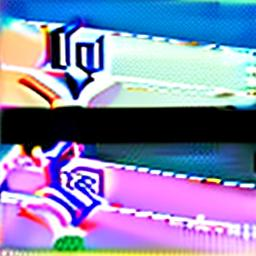

In [113]:

prediction = deployed_model.predict([["logo for an AI company named Verta",256,256,9,25]])
display_image(prediction[0])